# Overview of the evaluation module


This notebook demonstrates the evaluation of four bias adjustment methods - ISIMIP (Lange 2021), CDFt (Vrac 2017), Quantile Delta Mapping (Cannon et al 2015) and Quantile Mapping - to the variables tas (daily mean 2m surface temperature, K) and pr (total daily precipitation flux, kg/m2/s). ISIMIP is additionally applied to tasmin (daily minimum 2m surface temperature, K) and tasmax (daily maximum 2m surface temperature, K).

The notebook is structured along the following three components of the module:

- **Evaluating the bias adjusted model on a validation period**: In order to assess the performance of a bias adjustment method, the bias adjusted model data is compared to observational / reanalysis data. This component provides insight into the adjustment of marginal biases, as well as temporal, spatial and spatiotemporal metrics.
- **Investigating whether the climate change trend is preserved**: Bias adjustment methods can significantly modify the trend projected in the climate model simulation (Switanek 2017). This is also possible for methods that are explicitely trend-preserving. This component shows the bias in trend of different metrics between the raw and bias corrected climate model.
- **Testing assumptions of different debiasers**: Different bias adjustment methods rely on different assumptions - some are parametrics, others non-parametric, some bias correct each day of the year separately, others are applied to all days of the year in the same way. One of the reasons that a bias adjustment method could fail in a given use-case is that these assumptions are not met. This component provides a starting point for assessing the validity of different assumptions.

## Set-up and data pre-processing

This step requires the user to have downloaded and preprocessed observational or reanalysis data (such as ERA5) as well as simulations of a climate model during a historical and future (or application) period. Necessary pre-processing steps include regridding the datasets to the same area and grid in space and time and conducted checks for corrupted or missing data.

For the purpose of this demonstration, we will work with the testing data uploaded to the github folder of ibicus. This data is already preprocessed and numpy arrays of data have been extracted. We can get it using: 

```
!wget https://github.com/ecmwf-projects/ibicus/blob/main/notebooks/testing_data.zip -c
!unzip testing_data.zip
```

In [1]:
import numpy as np
import iris
import math

from scipy.stats import norm, laplace, gamma, beta

import sys

from ibicus.variables import *
from ibicus.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from ibicus.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from ibicus.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from ibicus.evaluate import assumptions, correlation, marginal, multivariate, trend
from ibicus.evaluate.metrics import *

The second component of the evaluation requires a split of the historical period into training and validation period.

In [7]:
def get_data(variable, path = "testing_data/", split_ratio = 0.7037):
    
    data = np.load(f"{path}{variable}.npz", allow_pickle = True)
    
    cut_off = math.floor(data["obs"].shape[0]*split_ratio)
    
    obs = data["obs"][0:cut_off, :, :]
    obs_validate = data["obs"][cut_off:, :, :]
    cm_hist = data["cm_hist"][0:cut_off, :, :]
    cm_validate = data["cm_hist"][cut_off:, :, :]
    cm_future = data["cm_future"]
    time_obs = data["time_obs"][0:cut_off]
    time_obs_validate = data["time_obs"][cut_off:]
    time_cm_hist = data["time_cm_hist"][0:cut_off]
    time_cm_validate = data["time_cm_hist"][cut_off:]
    time_cm_future = data["time_cm_future"]
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, time_obs, time_obs_validate, time_cm_hist, time_cm_validate, time_cm_future

In [8]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_time_obs, tas_time_obs_validate, tas_time_cm_hist, tas_time_cm_validate, tas_time_cm_future = get_data("tas")
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_time_obs, pr_time_obs_validate, pr_time_cm_hist, pr_time_cm_validate, pr_time_cm_future = get_data("pr")

## Initializing and applying the debiasers

The following section initializes and applies the debiasers ISIMIP, CDFt, Quantile Mapping (QM) and Quantile Delta Mapping (QDM) to the chosen variables. For a more detailed explanaition of the bias adjustment methods we refer to the documentation, and for some examples on how to customize different debiasers, we refer to the notebook on adjusting bias adjustment methods.

**ISIMIP**

In [14]:
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, parallel=True)
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, parallel=True)

In [15]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_validate, parallel=True)
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_future, parallel=True)

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3133: RuntimeWarning: divide by zero encountered in double_scalars
  aest = (3-s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3132: RuntimeWarning: invalid value encountered in double_scalars
  func = lambda a: np.log(a) - sc.digamma(a) - s
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3133: RuntimeWarning: divide by zero encountered in double_scalars
  aest = (3-s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3132: RuntimeWarning: invalid value encountered in double_scalars
  func = lambda a: np.log(a) - sc.digamma(a) - s


**CDFt**

In [19]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_val_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate)
tas_fut_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future)

100%|█████████████████████████████████████████| 225/225 [00:29<00:00,  7.72it/s]


In [20]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_val_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_validate)
pr_fut_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_future, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_future)

100%|█████████████████████████████████████████| 225/225 [00:30<00:00,  7.32it/s]


**Quantile Delta Mapping**

In [21]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, parallel=True)
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, parallel=True)

/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/debias/_debiaser.py:559: UserWarning: The debiaser output contains values outside the reasonable physical range of [100, 400] for the variable: Daily mean near-surface air temperature. This might be due to values outside the range in the input, or to a problem of the debiaser for the given dataset at hand. It is recommended to check the output carefully.
  self._check_output(output)


In [22]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_validate, parallel=True)
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_future, parallel=True)

/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/debias/_quantile_delta_mapping.py:322: RuntimeWarning: divide by zero encountered in divide
  cm_future
/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/debias/_debiaser.py:559: UserWarning: The debiaser output contains inf or nan values. This might be due to inf or nan values inside the input, or to a problem of the debiaser for the given dataset at hand. It is recommended to check the output carefully
  self._check_output(output)
/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/debias/_quantile_delta_mapping.py:322: RuntimeWarning: divide by zero encountered in divide
  cm_future


**Quantile Mapping**

In [23]:
tas_debiaser_QM = QuantileMapping.from_variable(variable = "tas")
tas_val_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_future)

pr_debiaser_QM = QuantileMapping.from_variable(variable = "pr")
pr_val_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_future)

100%|█████████████████████████████████████████| 225/225 [00:02<00:00, 91.77it/s]


## Part 2: Evaluation on validation dataset

### Overview: Statistical Properties and Threshold Metrics

There are two types of metrics that the evaluation module enables you to analyse: bias in the mean or statistical properties such as the 5th or 95th percentile, and bias in threshold metrics such as frost days or location-wise defined high mean daily temperature. The reason for including the second type of metrics is that it is often specific threshold metrics that are relevant for impact models (for example agricultural or hydrological models), and where the success of bias adjustment methods is particularly desirable. 

The following table gives an overview, which types of analysis are currently available in this release of the package.

|                  | Statistical Properties | Threshold Metrics  |
| ------------     | ---------------------- | -----------------  |
| **Marginal**     | x - marginal bias      | x - marginal bias  |
| **Temporal**     |                        | x - spell length   |
| **Spatial**      | x - RMSE corr matrices | x - spatial extent |
| **Spatioteporal**|                        | x - cluster size   |
| **Multivariate** | x - correlation        |                    |


A new threshold metric can be defined by the user by simply specifying at least the a) threshold value or values, b) the type of threshold (whether values above, below, between or outside the given threshold(s) are of interest: `threshold_type`), c) the variable it applies to and d) a metric name.

In [59]:
mean_frost_days = ThresholdMetric(name="Mean frost days (tas<0°C)", variable="tas", threshold_value=273.13, threshold_type="lower")

Thresholds defined per day, month or season are also possible using the `threshold_scope` argument, as well as per location (`threshold_locality`) or any combination of the two. Since precipitation is an accumulative variable, a child class with special features is defined for precipitation metrics.

In [ ]:
tas_heatwave = ThresholdMetric.from_quantile(tas_obs, 0.95, threshold_type = "higher", 
                                                        threshold_scope = "season", 
                                                        time = tas_time_obs), 
                                                        name = "Mean daily temperature >95th \n seasonal percentile of gridcell")

For each variable, the package implements a number of out-of-the-box metrics (accessible via `ibicus.evaluate.metrics`) which users can edit, next to creating new ones:

In [3]:
dry_days

AccumulativeThresholdMetric(threshold_value=1.1574074074074073e-05, threshold_type='lower', threshold_scope='overall', threshold_locality='global', name='Dry days \n (< 1 mm/day)', variable='pr')

In [4]:
dry_days.threshold_type ="lower"

A number of threshold metrics are associated with each variable by default:

In [99]:
tas_metrics = [warm_days, cold_days, mean_frost_days]
pr_metrics = [dry_days, wet_days, R10mm, R20mm]

Overall, all ETCCDI climate indices are fully integrated and compatible with the ibicus threshold metrics class (https://www.climdex.org/learn/indices/). 

### Location-wise evaluation

We first investigate the location-wise bias of the chosen metrics and descriptive statistics in a validation period. The plot below shows the distribution of marginal (location-wise) biases across locations. For the mean, this is for example calculated as follows:

$$ \text{Bias}_{ij} = 100 * \frac{\bar{\text{tas}}_{obs, ij} - \bar{\text{tas}}_{cm, ij}}{\bar{\text{tas}}_{obs, ij}} $$

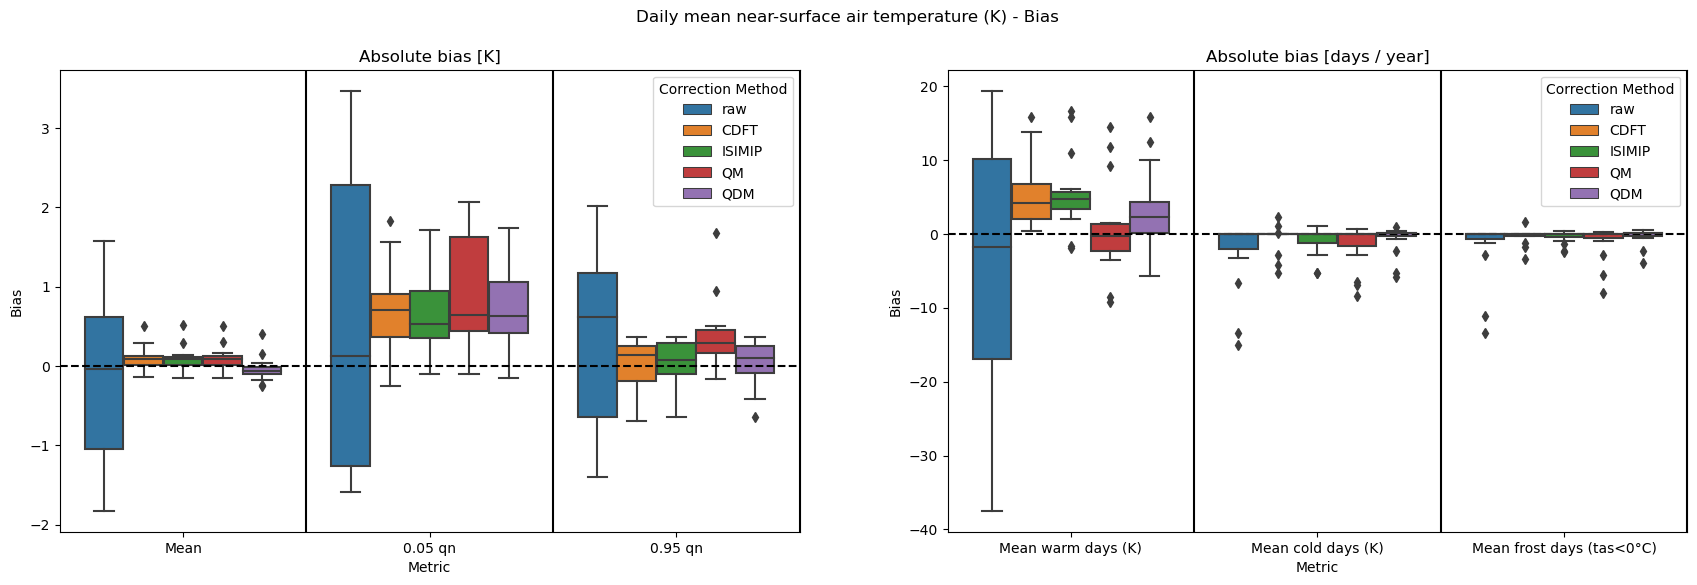

In [100]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics,
                                                          statistics = ['mean', [0.05, 0.95]],
                                                          percentage_or_absolute = 'absolute',
                                                          obs = tas_obs_validate,
                                                          raw = tas_cm_validate, 
                                                          CDFT = tas_val_debiased_CDFT,
                                                          ISIMIP = tas_val_debiased_ISIMIP,
                                                          QM = tas_val_debiased_QM, QDM = tas_val_debiased_QDM)

tas_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'tas', 
                                                     bias_df = tas_marginal_bias_data,
                                                    metrics_title = "Absolute bias [days / year]",
                                                    statistics_title = "Absolute bias [K]")
plt.show()

/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/evaluate/marginal.py:92: RuntimeWarning: divide by zero encountered in divide
  bias = 100 * (cm_metric - obs_metric) / obs_metric
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_94979/2804517872.py:1: UserWarning: raw: Division by zero encountered in bias of AccumulativeThresholdMetric(threshold_value=0.0002314814814814815, threshold_type='higher', threshold_scope='overall', threshold_locality='global', name='Extremely wet days \n (> 20 mm/day)', variable='pr') calculation, not showing results for this debiaser.
  pr_marginal_bias_data = marginal.calculate_marginal_bias(metrics = pr_metrics,
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_94979/2804517872.py:1: UserWarning: CDFT: Division by zero encountered in bias of AccumulativeThresholdMetric(threshold_value=0.0002314814814814815, threshold_type='higher', threshold_scope='overall', threshold_locality='global', name='Extremely wet days \n (> 20 mm/

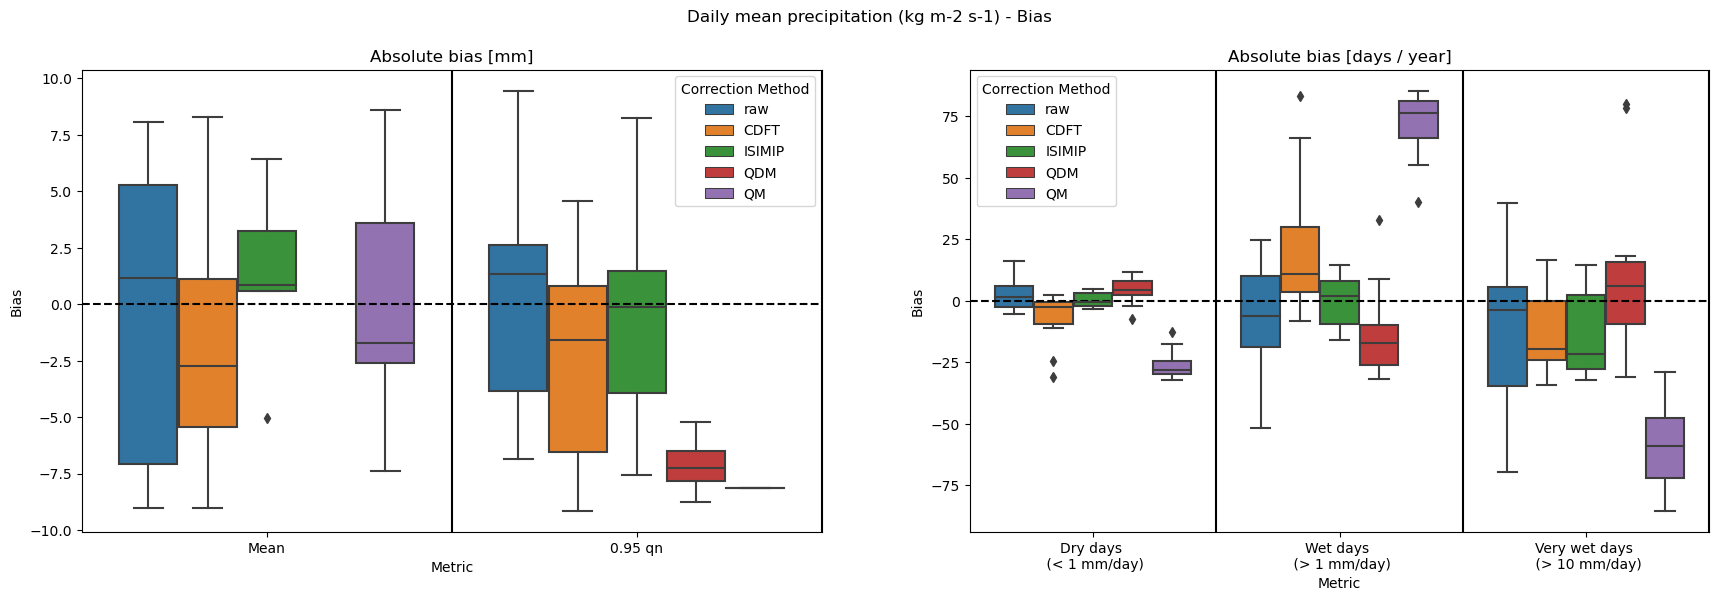

In [36]:
pr_marginal_bias_data = marginal.calculate_marginal_bias(metrics = pr_metrics, 
                                                         statistics = ['mean', [0.05, 0.95]],
                                                        percentage_or_absolute = 'percentage',
                                                         obs = pr_obs_validate,
                                                         raw = pr_cm_validate, 
                                                         CDFT = pr_val_debiased_CDFT,
                                                         ISIMIP = pr_val_debiased_ISIMIP,
                                                         QDM = pr_val_debiased_QDM,
                                                         QM = pr_val_debiased_QM)

pr_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'pr', 
                                                    bias_df = pr_marginal_bias_data,
                                                   remove_outliers = True,
                                                   outlier_threshold_statistics = 10,
                                                   metrics_title = 'Absolute bias [days / year]',
                                                   statistics_title = 'Absolute bias [mm]')
plt.show()

**Spatial distribution of marginal biases**: The boxplots above plot the bias across locations. To investigate this further, we can plot the bias spatially. The function shown below works with input of the type produced by the output of the 'calculate_marginal_bias' function, and produces simple heatmaps that have no further package dependencies other than numpy. The user can build on this to produce more sophisticated plots using packages such as xarray.

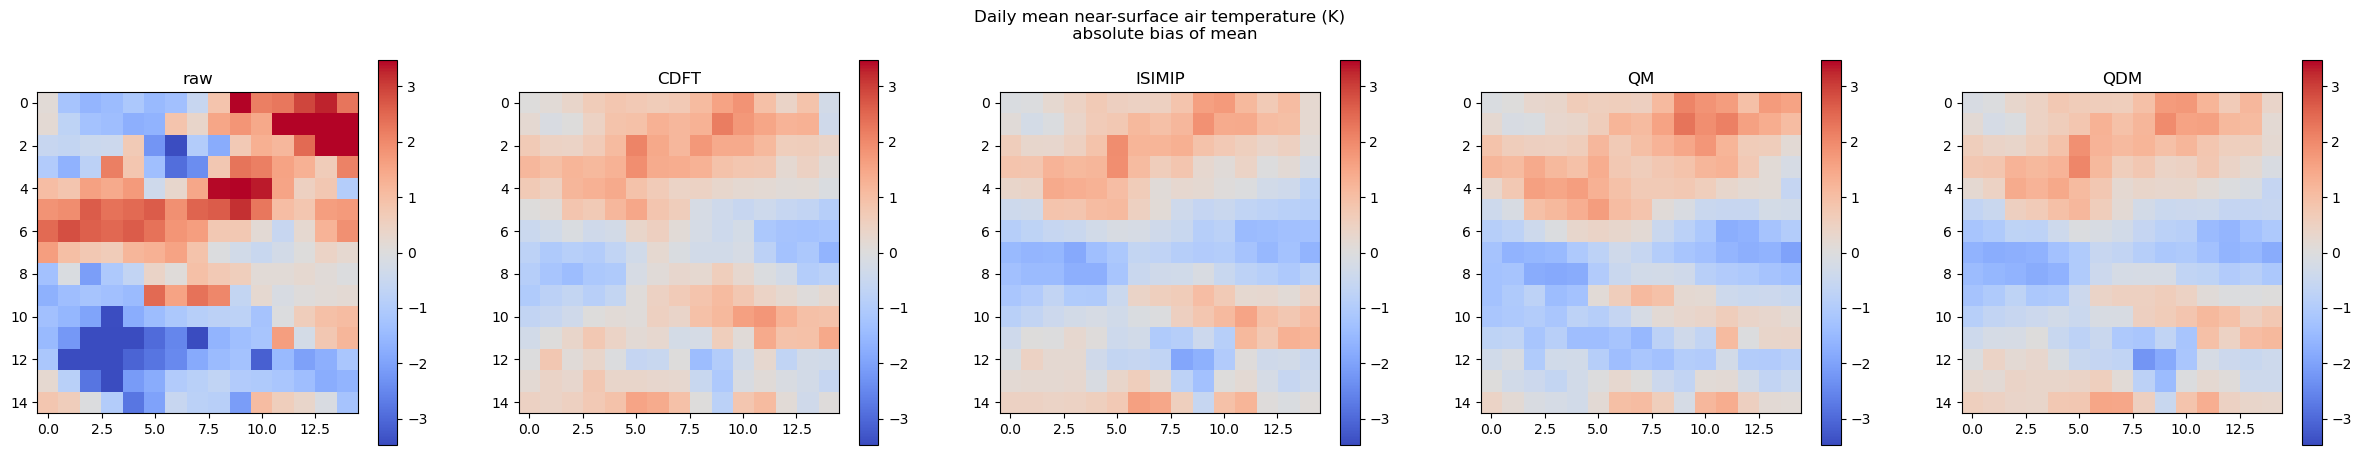

In [42]:
tas_bias_map_mean = marginal.plot_bias_spatial(variable = 'tas', metric = '0.05 qn', bias_df = tas_marginal_bias_data)

/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/utils/_utils.py:464: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in row.iteritems():


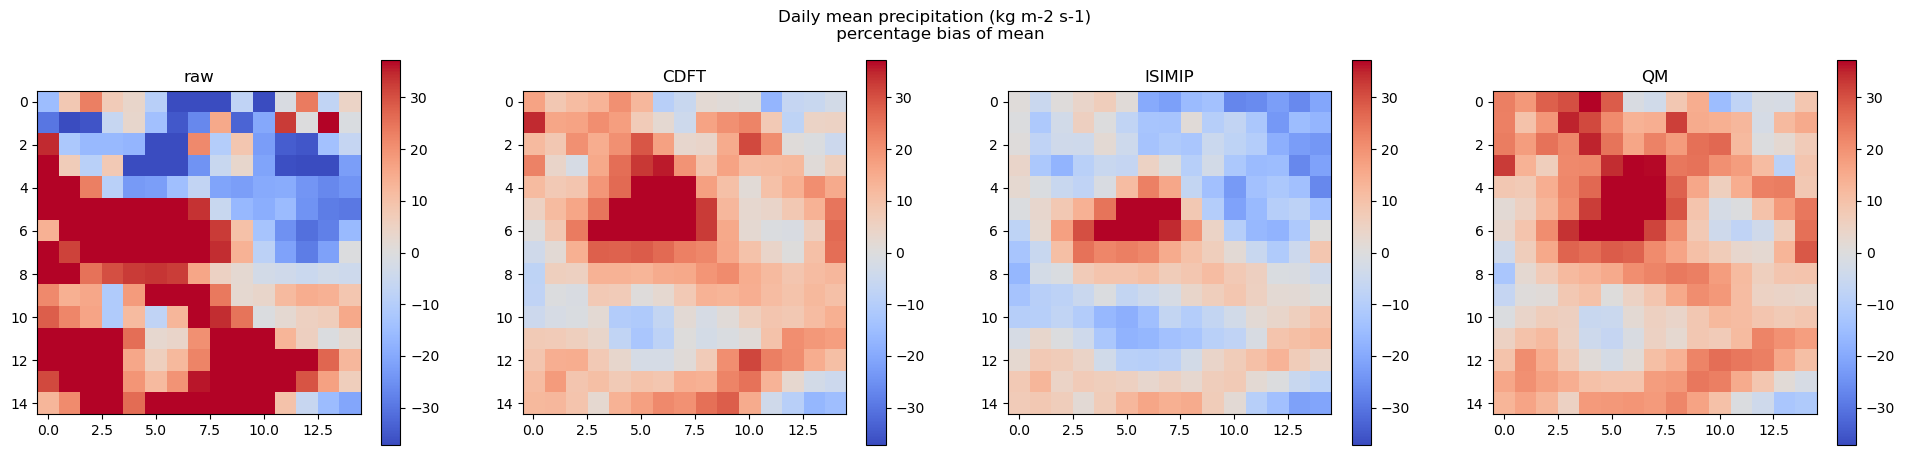

In [54]:
pr_bias_map_mean = marginal.plot_bias_spatial(variable = 'pr', metric = 'Mean', bias_df = pr_marginal_bias_data)

### Spatial, temporal and spatiotemporal properties 

For each threshold metric, the temporal spell length, the spatial extent and the 'spatiotemporal cluster size' can be calculated as follows:

- Spell length: counts the number of temporally consecutive threshold exceedances at each location. 
- Spatial extent: percentage of the area is beyond the threshold, given that one location is above the threshold.
- Spatiotemporal clusters: spatiotemporally connected sets of threshold exceedance across the data.

In [46]:
spelllength_dry = dry_days.calculate_spell_length(minimum_length= 3,
                              obs = pr_obs_validate,
                              raw = pr_cm_validate, CDFT = pr_val_debiased_CDFT,
                              ISIMIP = pr_val_debiased_ISIMIP,
                              QM = pr_val_debiased_QM,
                              QDM = pr_val_debiased_QDM
    )

spatiotemporal_dry = dry_days.calculate_spatiotemporal_clusters(
                              obs = pr_obs_validate,
                              raw = pr_cm_validate, CDFT = pr_val_debiased_CDFT,
                              ISIMIP = pr_val_debiased_ISIMIP,
                              QM = pr_val_debiased_QM,
                              QDM = pr_val_debiased_QDM
    )

spatial_dry = dry_days.calculate_spatial_extent(
                              obs = pr_obs_validate,
                              raw = pr_cm_validate, CDFT = pr_val_debiased_CDFT,
                              ISIMIP = pr_val_debiased_ISIMIP,
                              QM = pr_val_debiased_QM,
                              QDM = pr_val_debiased_QDM)

A useful way of visualising these metrics is to plot their empirical cumulative distribution functions as visual identification of differences in the distributions are possible more easily.

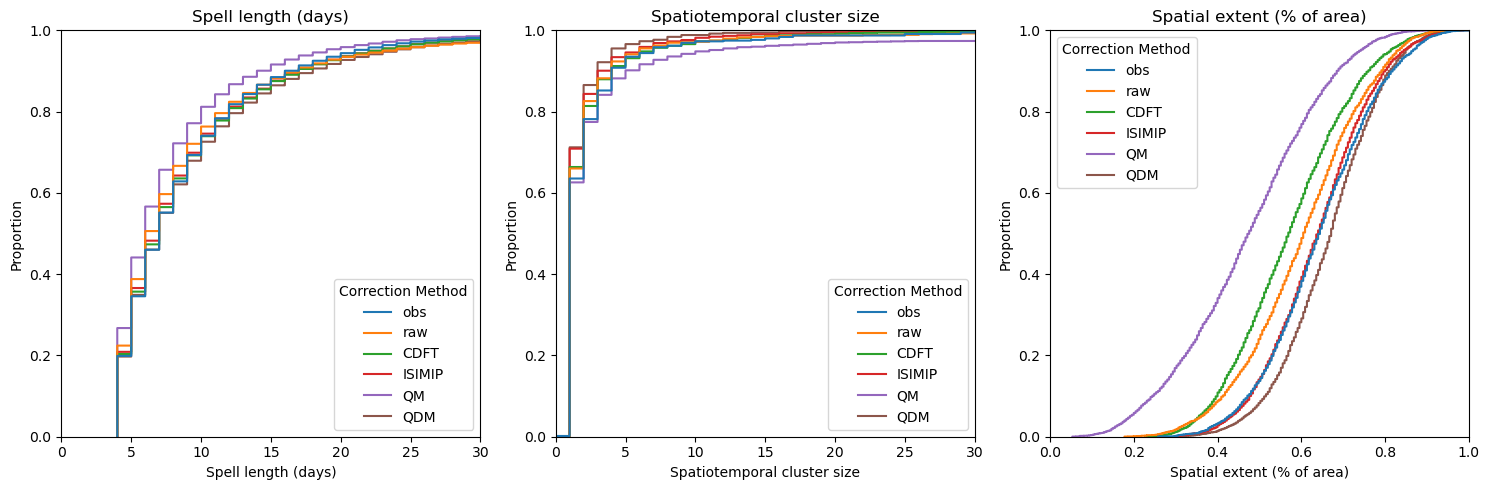

In [57]:
spatiotemporal_fig = marginal.plot_spatiotemporal(data = [spelllength_dry, spatiotemporal_dry, spatial_dry])

We see that bias adjustment can significantly modify the spatiotemporal extent of threshold metrics. Depending on the application case and context, individual spatiotemporal extent metrics can and should be investigated in more detail.

So far, the spatiotemporal evaluation has focused on threshold metrics. To evaluate the spatial correlation for a single variable, a function to calculate the RMSE between the observed and the model correlation matrix for a single location is currently implemented in ibicus. At each location, the RMSE between the correlation matrix of this location with all others in the observational data, and the correlation matrix in the climate model data is calculated and output in the following map as a single number at each location.

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_94979/777485544.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


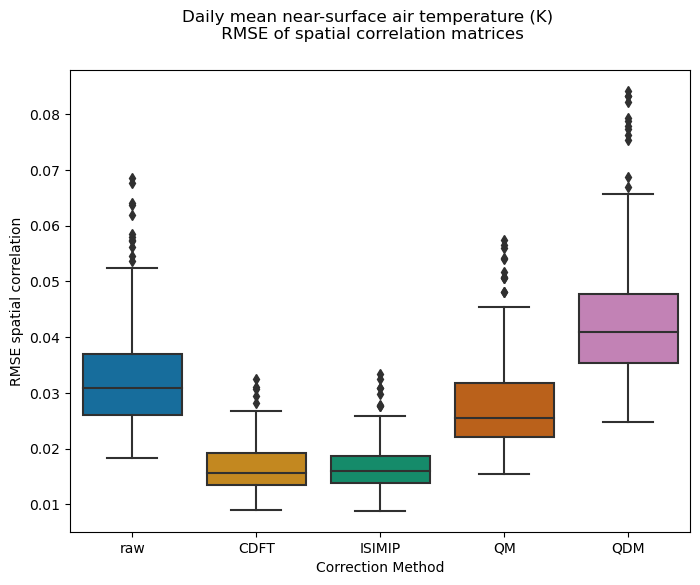

In [47]:
tas_rmsd_spatial = correlation.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                                     obs_data = tas_obs_validate, raw = tas_cm_future,
                                                                     CDFT = tas_val_debiased_CDFT,
                                                                     ISIMIP = tas_val_debiased_ISIMIP,
                                                                     QM = tas_val_debiased_QM, 
                                                                     QDM = tas_val_debiased_QDM
                                                                     )
tas_rmsd_spatial_plot = correlation.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

### Multivariate structure

**Conditional joint threshold exceedance of threshold metrics**

To investigate the compounding of different threshold metrics, ibicus so far enables the user to calculate their conditional joint threshold exceedance:

$$ p (\text{Metric1} | \text{Metric2}) = \frac {p(\text{Metric1} , \text{Metric2})}{p(\text{Metric2})} $$

In this example, we calculate the probability of warm days, given that these days are also wet (see definitions of threshold metrics above). The plot shows the mean conditional exceedance probability at each location.

In [80]:
warm_wet = multivariate.calculate_conditional_joint_threshold_exceedance(warm_days, wet_days,
                                                             obs = [tas_obs_validate, pr_obs_validate], 
                                                             raw = [tas_cm_validate, pr_cm_validate],
                                                            ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP],
                                                                         QM = [tas_val_debiased_QM, pr_val_debiased_QM],
                                                                         CDFT = [tas_val_debiased_CDFT, pr_val_debiased_CDFT])



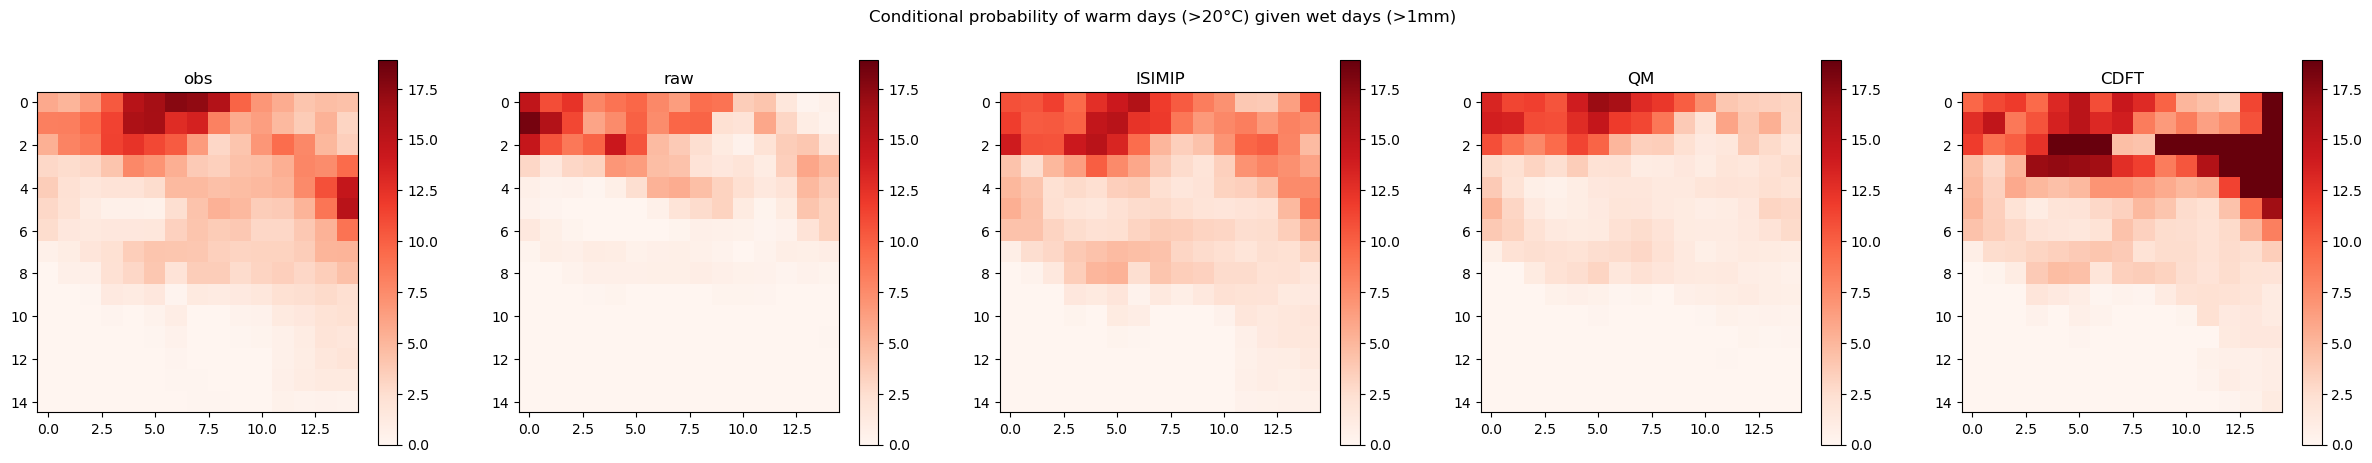

In [98]:
warm_wet_vis = multivariate.plot_conditional_probability_spatial(bias_df=warm_wet, plot_title ="Conditional probability of warm days (>20°C) given wet days (>1mm)")
plt.show()

**Correlation Structure**

This section is currently in an experimental phase and will be expanded upon in the next releases. Currently, it is possible to calculate and plot the correlation between two variables at each grid point, as shown below.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


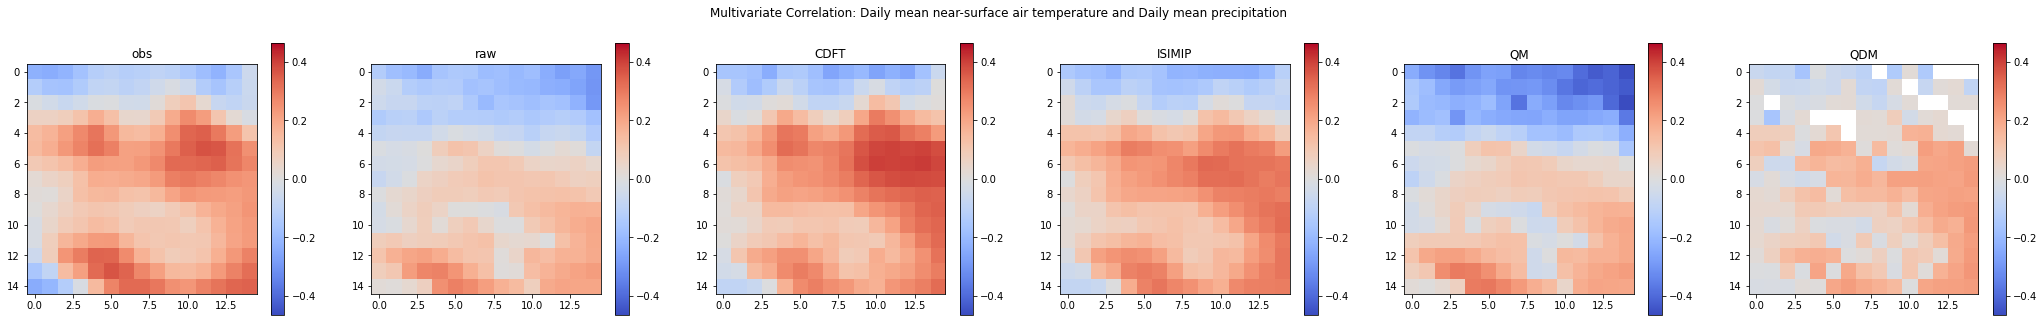

In [39]:
tas_pr_corr = multivariate.calculate_and_spatialplot_multivariate_correlation(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], CDFT = [tas_val_debiased_CDFT, pr_val_debiased_CDFT],
                                                               ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP],
                                                               QM = [tas_val_debiased_QM, pr_val_debiased_QM],
                                                                QDM = [tas_val_debiased_QDM, pr_val_debiased_QDM])
plt.show()

It is also possible to plot the two variables as well as their correlation with each other at a single location:

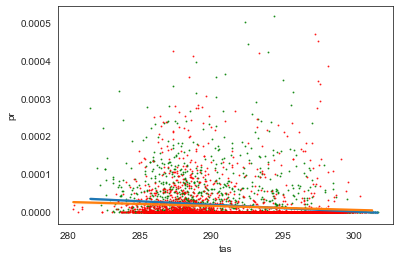

In [41]:
tas_pr_obs, tas_pr_isimip = multivariate.create_multivariate_dataframes(variables = ['tas', 'pr'], datasets_obs = [tas_obs_validate, pr_obs_validate], 
                                                            datasets_bc = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP], gridpoint = (1,1))

tas_pr_corr_11 = multivariate.plot_correlation_single_location(variables = ['tas', 'pr'], obs_df = tas_pr_obs, bc_df = tas_pr_isimip)

At a single location, it is also possible to use bootstrapping to obtain a distribution of estimates of the correlation:

KstestResult(statistic=0.912, pvalue=1.0657876044847793e-222)


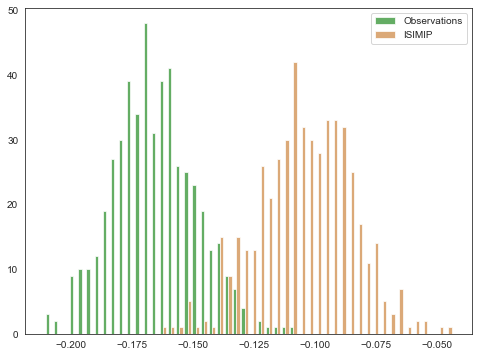

In [42]:
tas_pr_corr_bs = multivariate.plot_bootstrap_correlation_replicates(obs_df = tas_pr_obs, bc_df = tas_pr_isimip,
                                                                    bc_name = 'ISIMIP', size = 500)

## Part 3: Evaluation of trend preservation


This last section investigates whether the chosen bias adjustment method modify the trend in the climate model between the validation and the future period. The following steps are conducted in the calculation:
- First, the trend in the chosen statistic (for example the mean) between the validation period and the future period in the *raw* climate model is calculated. 
- Then, the same calculation is performed for the debiased models of interest
- Finally the percentage difference between these two trends is calculated.

/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/evaluate/trend.py:170: RuntimeWarning: divide by zero encountered in divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend
/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/evaluate/trend.py:170: RuntimeWarning: invalid value encountered in divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend
/Users/fionaspuler/Documents/GitHub/ibicus/notebooks/../ibicus/utils/_utils.py:464: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in row.iteritems():


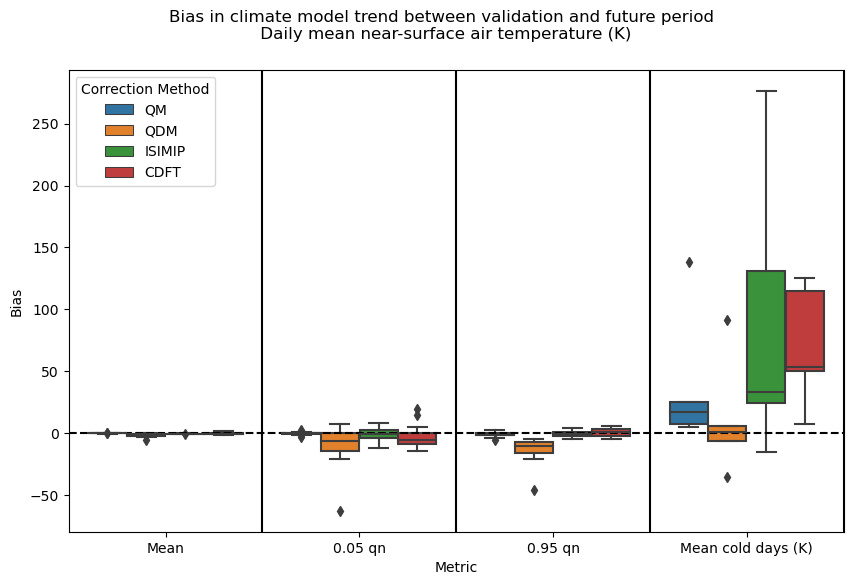

In [102]:
tas_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tas', 
                                                        trend_type = 'additive',
                                                  raw_validate = tas_cm_validate, raw_future = tas_cm_future,
                                                        metrics = tas_metrics,
                                                  QM = [tas_val_debiased_QM, tas_fut_debiased_QM],
                                                        QDM = [tas_val_debiased_QM, tas_fut_debiased_QDM],
                                                  ISIMIP = [tas_val_debiased_ISIMIP, tas_fut_debiased_ISIMIP],
                                                  CDFT = [tas_val_debiased_CDFT, tas_fut_debiased_CDFT])

tas_trend_plot = trend.plot_future_trend_bias_boxplot(variable ='tas', bias_df = tas_trend_bias_data,                                                         remove_outliers = True,
                                                        outlier_threshold = 500,)
plt.show()

Wee see that while the trend in mean and 95th percentile is decently preserved in delta-QM, ISIMIP and CDFt, it is modified more in the Quantile Delta Mapping method.

## Part 3: Testing assumptions

A detailed overview of assumptions associated with a specific bias adjustment method can be found in the documentation of each bias adjustment method. For the sake of demonstration, we investigate the goodness of fit and seasonality here - this should be seen as an example of one possible assumption to investigate further that can be adapted further to the bias adjustment used.

For all parametric methods, distributions are fitted to both the climate model and the observational data. Default distributions for each variable are specified in the individual methods. We assess the following two components:
- Is the fit of the default distribution 'good enough' or should a different distribution be used? (1)
- Is there any seasonality in the data that should be accounted for, for example by applying a 'running window mode' (meaning that the bias adjustment is fitted separately for different parts of the year, i.e. windows)? (2)

**Calculating the AIC and plottinge the worst fit**

The Akaike Information Criterion is a statistical method for comparative evaluation of different statistical models. The AIC weighs model complexity with goodness of fit, with a lower AIC indicating a 'better model', and is computed as follows: 

$$ AIC = 2 \frac{k}{n} - 2 \frac{l}{n}$$

whereby $l$ is the log likelihood function calculated in the following way:

$$ l = - \frac{n}{2} (1+ \ln(2 \pi) + \ln (\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2)) $$

To demonstrate, we test the fit of the normal and the beta distribution to the temperature data:

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[Text(0.5, 1.0, 'Distribution of AIC values across locations \n Daily mean near-surface air temperature')]

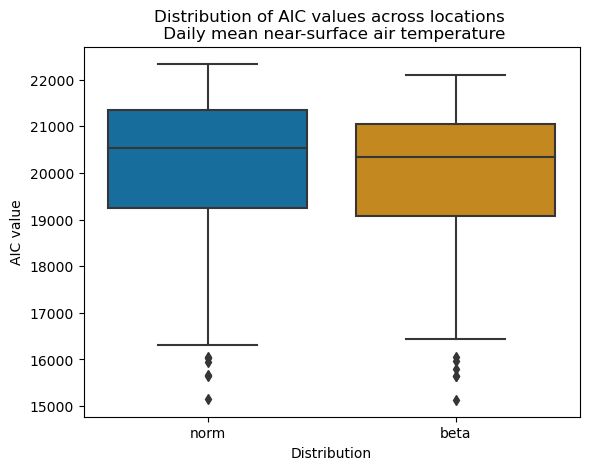

In [10]:
tas_obs_aic = assumptions.calculate_aic('tas', tas_obs_validate, scipy.stats.norm, scipy.stats.beta)

assumptions.plot_aic(variable = 'tas', aic_values = tas_obs_aic)

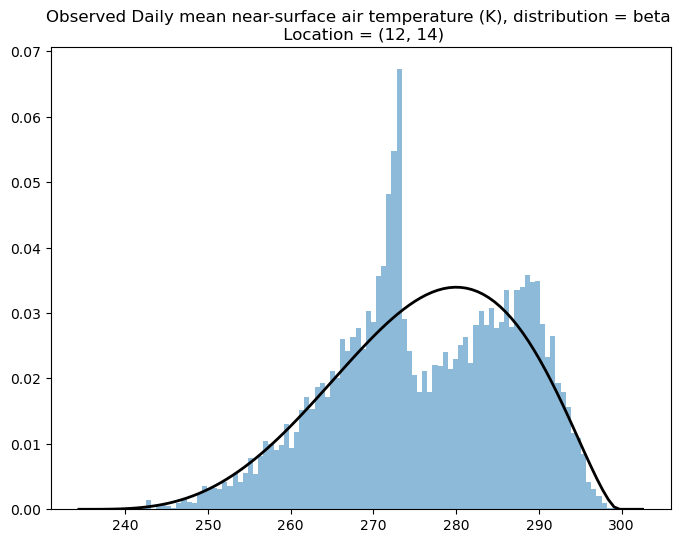

In [11]:
tas_obs_worst_fit = assumptions.plot_fit_worst_aic(variable = 'tas', dataset = tas_obs,  
                                                   data_type = 'Observed', distribution = scipy.stats.beta,
                                                   nr_bins = 100, aic_values = tas_obs_aic)

Given the plot we see above, and the strong bi-modal distribution of the temperature data, we make the assumption that might be seasonal variation at play here. This can be further investigated by using the following function: it plots the time-series and autocorrelation function of the quantile residuals. It also plot a QQ plot of the normalized quantile residuals to get a picture of the goodness of fit for different quantiles. 

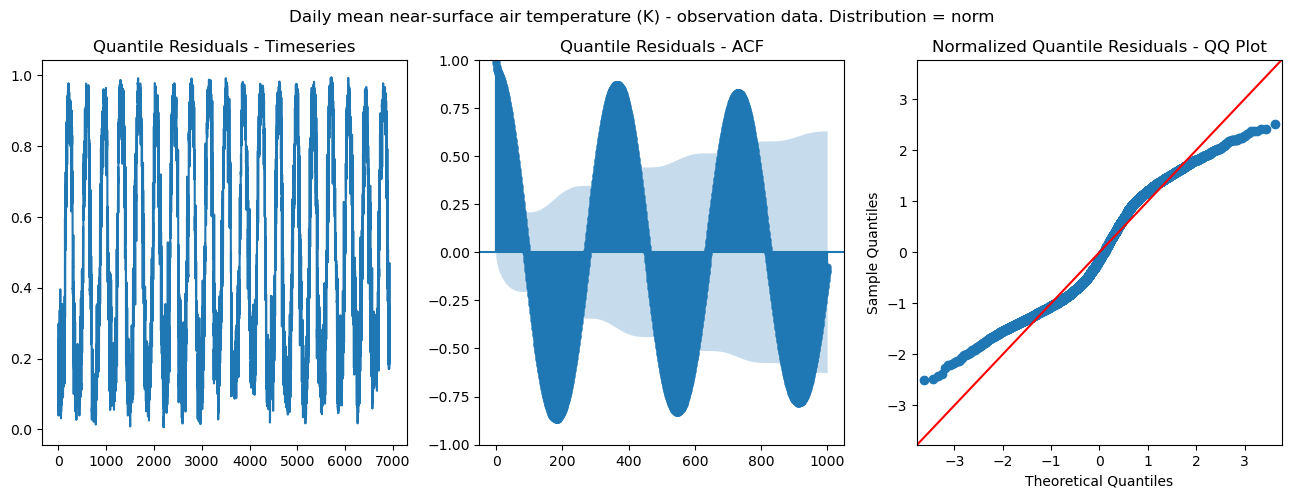

In [12]:
tas_obs_plot_gof = assumptions.plot_quantile_residuals(variable = 'tas', dataset = tas_obs[:,0,0], data_type = 'observation data',
                                                      distribution = scipy.stats.norm)

Overall the distributions do not fit the tempereature data well due to the bi-modal distribution of temperature. Based on the quantile residuals, we can see that there is a strong seasonality at play. One option to address this issue is to build a statistical model that explicitely includes the season as covariate. An alternative approach is to use a so-called 'running-window-mode' (applied for example in the QDM and ISIMIP debiasers) where a separate mapping is conducted each day (or month) of the year, which also takes care of the seasonality. For more details on the running-window-mode, have a look at the documentation of different debiasers.

## Conclusion

This notebook provides an overview of the different types of evaluation metrics that can be applied as part of ibicus. For the variables and region studied, ISIMIP and CDFt perform best across metrics, although the choice of debiaser for a specific case-study will depend on the metrics the user is most interested in, as well as an understanding of the source of the climate model bias for the variable of interest.

We hope this notebook provides helpful guidance for you to evaluate your own bias adjustment project and choose the methodology most suited to your application.